In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import nrrd

import pyvista as pv
pv.set_plot_theme("document")
pv.start_xvfb()

### for enabling latex with pyvista
import vtk
vtk_mathtext = vtk.vtkMathTextFreeTypeTextRenderer()
vtk_mathtext.MathTextIsSupported()

True

In [127]:
image, _ = nrrd.read("../../data/ASOCA/Normal/CTCA/Normal_17.nrrd")

truth_path = "../../data_flat/Annotation_Normal_17.nrrd"
nrrd_data, nrrd_header = nrrd.read(truth_path)
lbl = np.array(nrrd_data)

prediction_path = "../../project/model1_auto3dseg/segresnet_0/prediction_testing/CTCA_Normal_17.nii.gz"
prediction_nib = nib.load(prediction_path)
pred = np.array(prediction_nib.dataobj)

im_shape = pred.shape

83

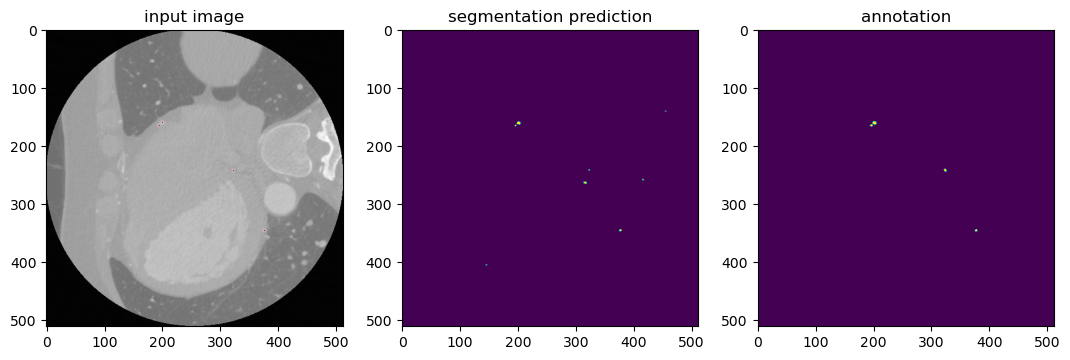

In [128]:
i = np.random.randint(image.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(image[:, :, i], cmap="gray")
arr = lbl[:,:,i].astype(float)
arr[arr == 0] = np.nan
axs[0].imshow(arr, cmap="bwr_r")

axs[1].set_title("segmentation prediction")
axs[1].imshow(pred[:,:,i], cmap="viridis")

axs[2].set_title("annotation")
axs[2].imshow(lbl[:,:,i], cmap="viridis")

i

In [4]:
lbl.shape

(512, 512, 224)

In [5]:
# Create a 3D mesh
mesh = pv.wrap(lbl)

# take only the detected aortas (value = 1)
contour = mesh.contour([1], "values")

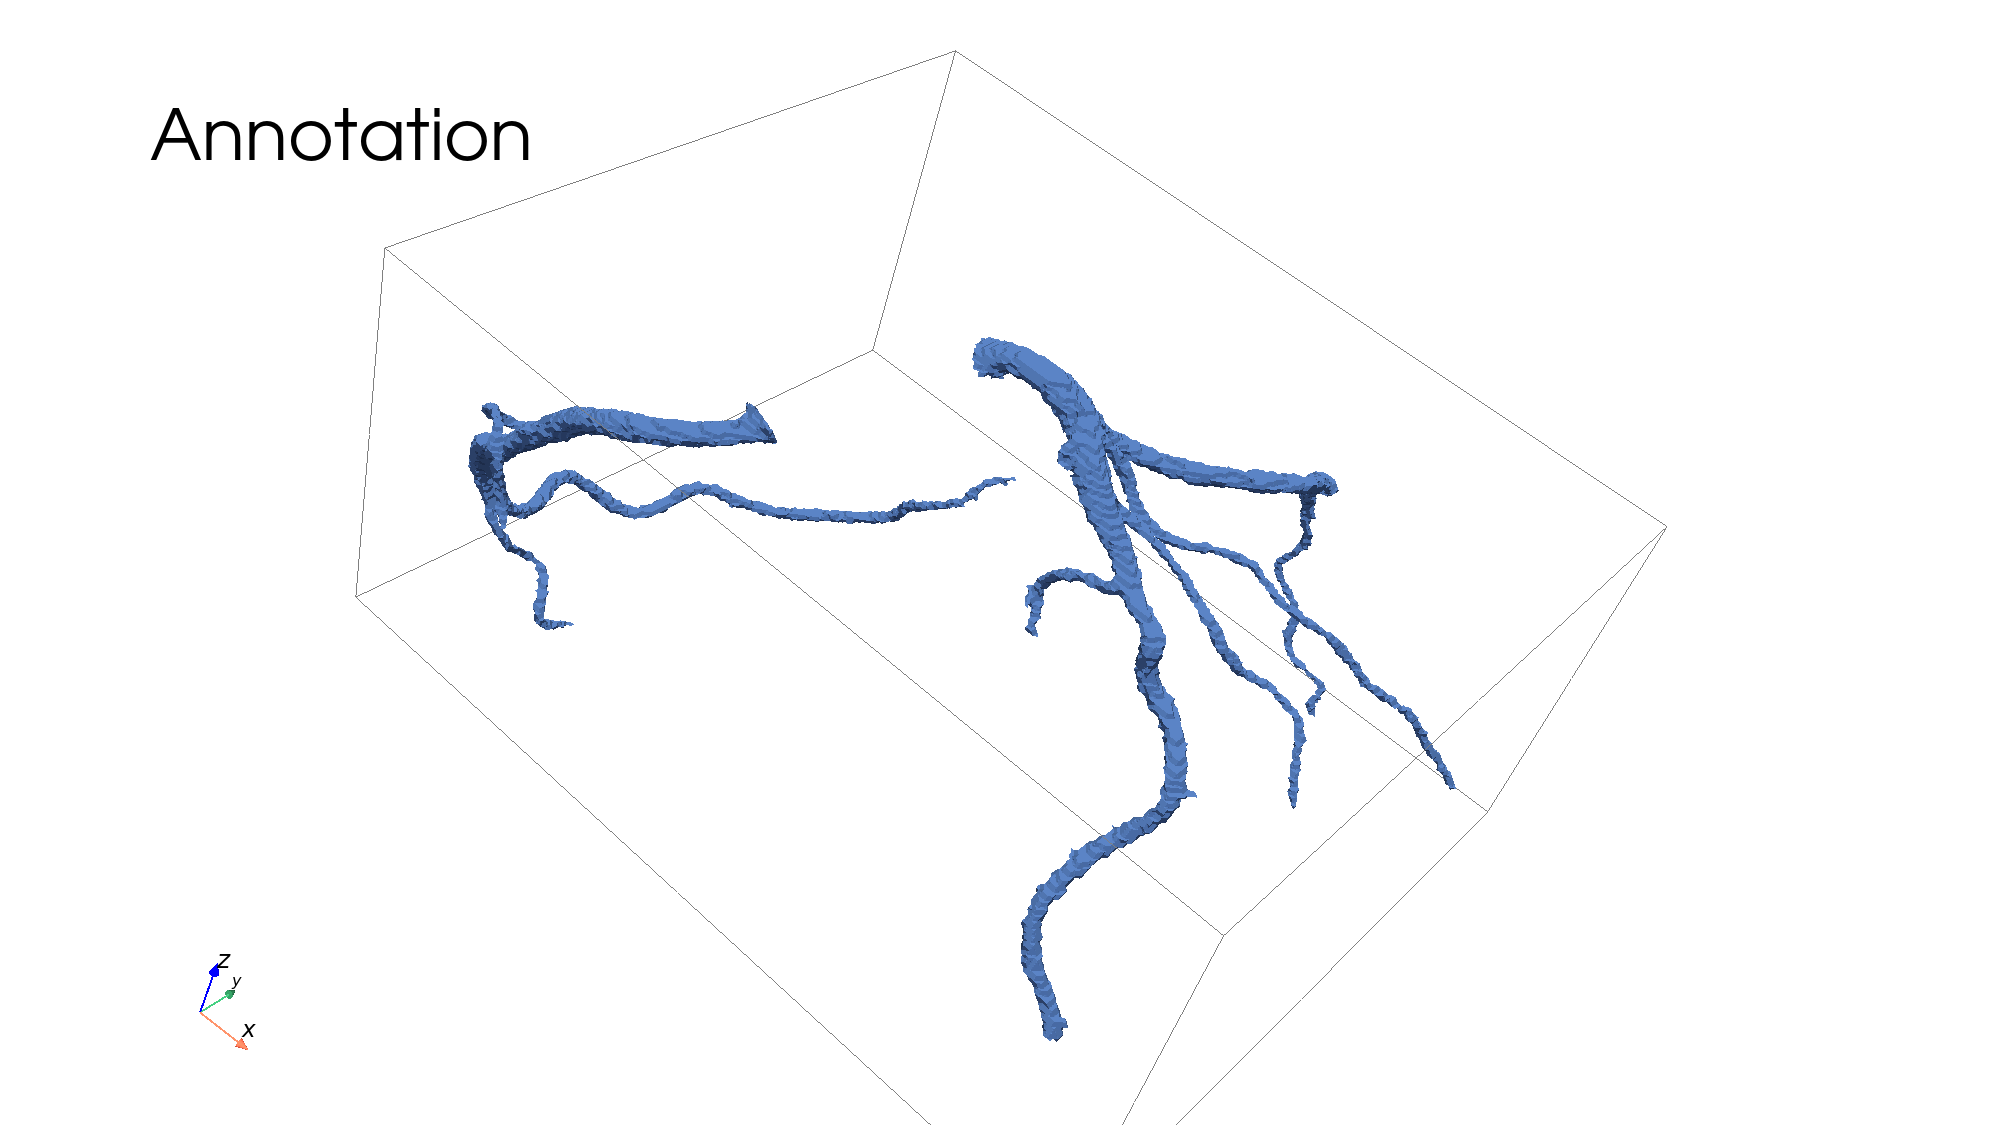

In [6]:
res = 2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
plotter.add_bounding_box(line_width=0.01)
plotter.add_text("Annotation", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

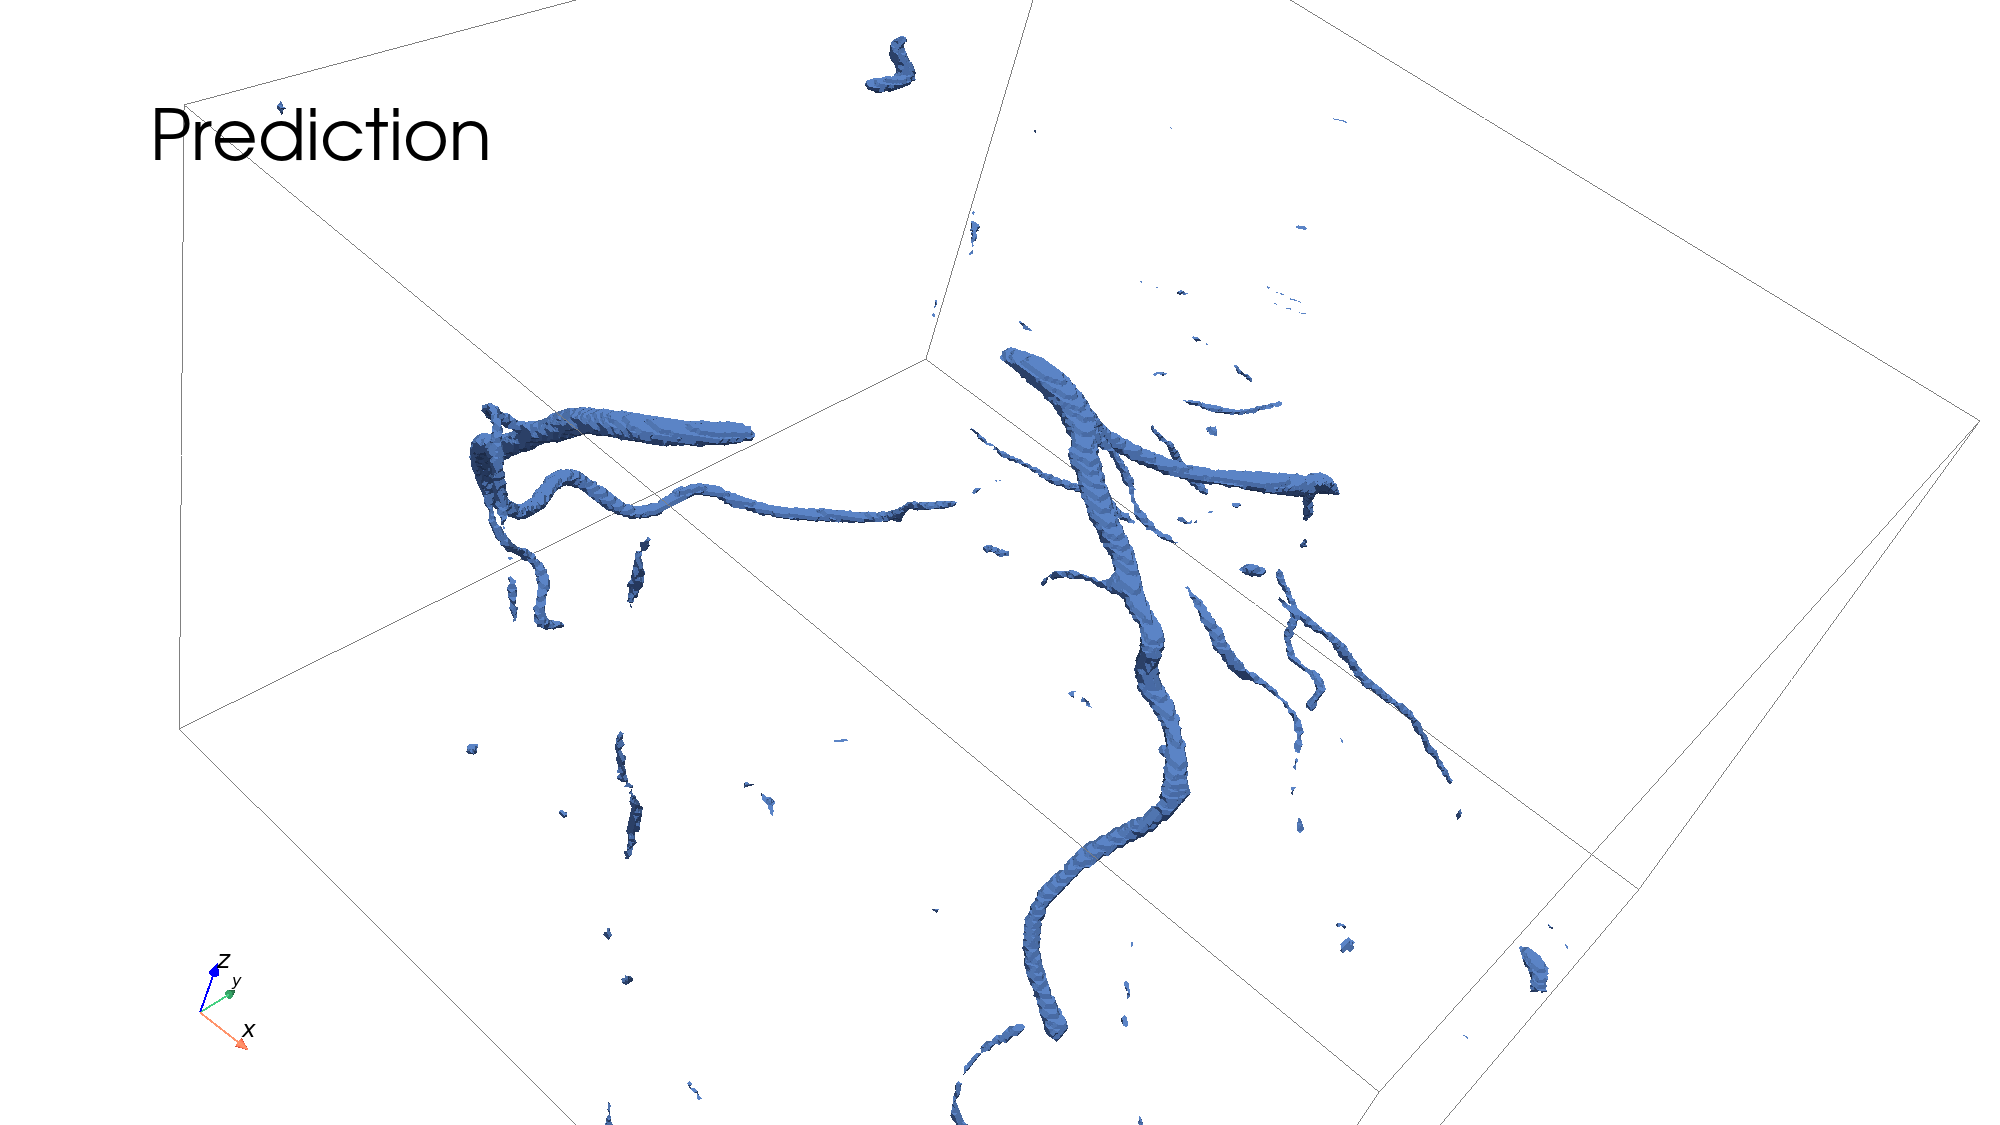

In [7]:
# Create a 3D mesh
mesh_2 = pv.wrap(pred)

# take only the detected aortas (value = 1)
contour_2 = mesh_2.contour([1], "values")


res = 2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour_2, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
plotter.add_bounding_box(line_width=0.01)
plotter.add_text("Prediction", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

In [193]:
## postprocessing: remove unconnected and small components

from scipy.cluster import hierarchy

# Extract the surface as a NumPy array
surface = contour_2.points

# Compute pairwise distances between surface points
distances = hierarchy.distance.pdist(surface)

# Apply hierarchical clustering to the distances
n_clusters = 30     # Number of initial clusters
clusters = hierarchy.fcluster(hierarchy.linkage(distances), t=n_clusters, criterion='maxclust')


# Extract the points in each cluster
cluster_points = []
for i in range(1, n_clusters+1):
    cluster_mask = clusters == i
    cluster_points.append(surface[cluster_mask])


# set threshold to remove small structures
cluster_threshold = 200
cluster_points = [cl for cl in cluster_points if len(cl)>cluster_threshold]

In [194]:
# # Plot each cluster with a different color
# plotter = pv.Plotter(window_size=(res, int(9/16*res)))

# for i in range(len(cluster_points)):
#     cluster_mesh = pv.PolyData(cluster_points[i])
#     cluster_mesh['cluster'] = np.full(len(cluster_points[i]), i+1, dtype=int)
#     plotter.add_mesh(cluster_mesh, scalars='cluster', opacity=0.5, cmap="turbo",
#                         # https://matplotlib.org/stable/tutorials/colors/colormaps.html
#                         scalar_bar_args=dict(title='Cluster', position_x=0.18, position_y=0.9, color="k", font_family='Times',
#                         n_labels=len(cluster_points), height=0.075, title_font_size=int(0.0175*res), label_font_size=int(0.015*res), fmt="%.0f"))      

# plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
#  (290.5, 274.0, 120.0),
#  (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(jupyter_backend='static')

In [195]:
contour_2_postproc = pv.PolyData(np.concatenate(cluster_points))

np_ndarr = np.zeros(im_shape, dtype=int)
contour_2_indices = contour_2_postproc.points.astype(int)
np_ndarr[contour_2_indices[:, 0], contour_2_indices[:, 1], contour_2_indices[:, 2]] = 1

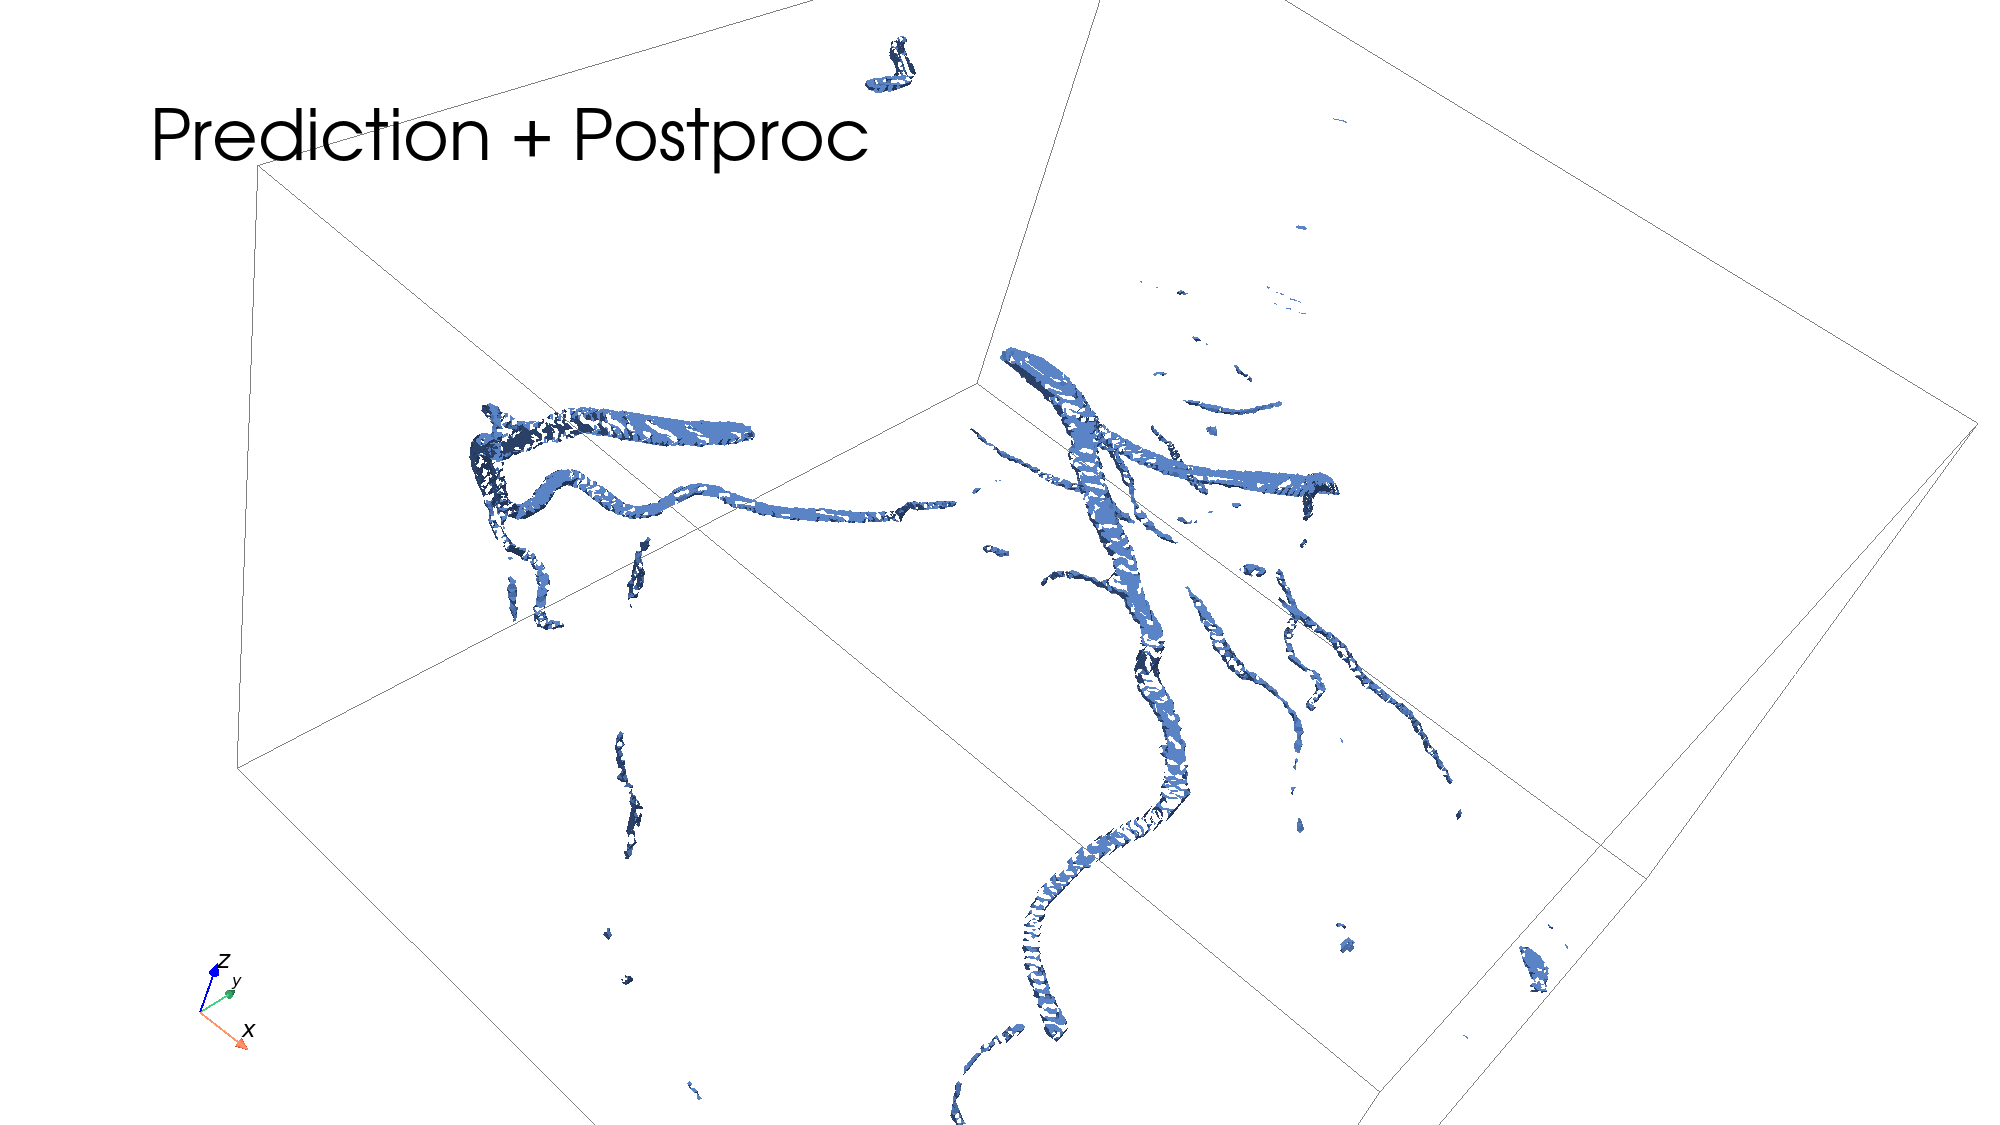

In [196]:
# Create a 3D mesh
mesh_3 = pv.wrap(np_ndarr)

# take only the detected aortas (value = 1)
contour_3 = mesh_3.contour([1], "values")

res = 2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour_3, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
plotter.add_bounding_box(line_width=0.01)
plotter.add_text("Prediction + Postproc", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

In [135]:
# import numpy as np

# # Create an empty numpy array with shape (512, 512, 224)
# array_shape = (512, 512, 224)
# interpolated_array = np.zeros(array_shape)

# # Define the coordinates of your PyVista contour (shape: (14013, 3))
# contour_coordinates = contour_2.points

# # Map the coordinates to numpy array indices
# x_indices = np.interp(contour_coordinates[:, 0], (152.0, 477.0), (0, 511))
# y_indices = np.interp(contour_coordinates[:, 1], (120.0, 485.0), (0, 511))
# z_indices = np.interp(contour_coordinates[:, 2], (26.0, 199.0), (0, 223))

# # Set the values within the contour to 1
# interpolated_array[x_indices.astype(int), y_indices.astype(int), z_indices.astype(int)] = 1

# # Now `interpolated_array` contains your desired 3D array


163

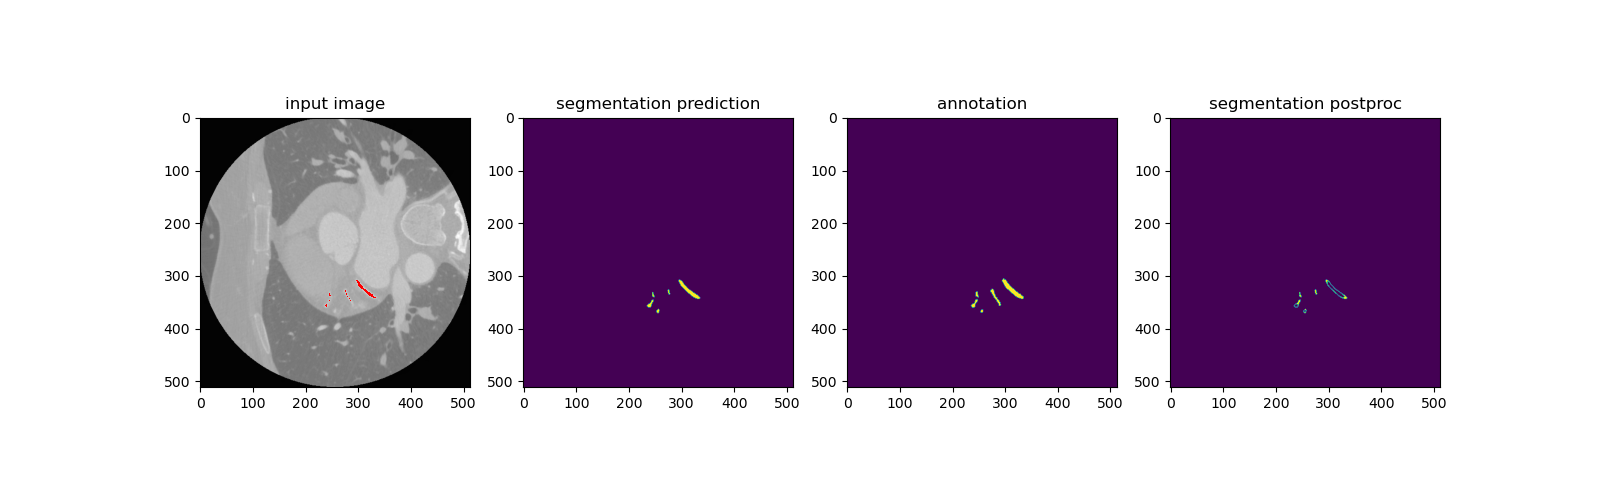

In [203]:
%matplotlib widget

i = np.random.randint(image.shape[2]-1)

fig, axs = plt.subplots(1, 4, figsize=(16, 5))

axs[0].set_title("input image")
axs[0].imshow(image[:, :, i], cmap="gray")
arr = lbl[:,:,i].astype(float)
arr[arr == 0] = np.nan
axs[0].imshow(arr, cmap="bwr_r")

axs[1].set_title("segmentation prediction")
axs[1].imshow(pred[:,:,i], cmap="viridis")

axs[2].set_title("annotation")
axs[2].imshow(lbl[:,:,i], cmap="viridis")

axs[3].set_title("segmentation postproc")
axs[3].imshow(np_ndarr[:,:,i], cmap="viridis")

i